In [162]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [163]:
# Download historical data for SPY
spy_data = yf.download('SPY', start='2010-01-01', end='2023-12-31')

# Reset index to make Date a column
spy_data.reset_index(inplace=True)

# Select relevant features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Date']
spy_data = spy_data[features]

# Ensure the Date column is in datetime format
spy_data['Date'] = pd.to_datetime(spy_data['Date'])

# Create new features
spy_data['Day_of_Week'] = spy_data['Date'].dt.dayofweek  # Monday=0, Sunday=6
spy_data['Month'] = spy_data['Date'].dt.month  # January=1, December=12

spy_data.drop(columns='Date', inplace=True)

spy_data['EMA12'] = spy_data['Close'].ewm(span=12, adjust=False).mean()
spy_data['EMA26'] = spy_data['Close'].ewm(span=26, adjust=False).mean()
spy_data['MACD'] = spy_data['EMA12'] - spy_data['EMA26']  # MACD line
spy_data['Signal_Line'] = spy_data['MACD'].ewm(span=9, adjust=False).mean()  # Signal line
spy_data['MACD_Histogram'] = spy_data['MACD'] - spy_data['Signal_Line']  # MACD Histogram

# CCI (Commodity Channel Index)
typical_price = (spy_data['High'] + spy_data['Low'] + spy_data['Close']) / 3
mean_deviation = lambda x: np.mean(np.abs(x - x.mean()))
spy_data['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).apply(mean_deviation))

# ATR (Average True Range)
high_low = spy_data['High'] - spy_data['Low']
high_close = np.abs(spy_data['High'] - spy_data['Close'].shift())
low_close = np.abs(spy_data['Low'] - spy_data['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
spy_data['ATR'] = true_range.rolling(window=14).mean()

# Bollinger Bands (BOLL)
spy_data['20_MA'] = spy_data['Close'].rolling(window=20).mean()
spy_data['20_STD'] = spy_data['Close'].rolling(window=20).std()
spy_data['Upper_Band'] = spy_data['20_MA'] + (2 * spy_data['20_STD'])
spy_data['Lower_Band'] = spy_data['20_MA'] - (2 * spy_data['20_STD'])

# EMA20 (20-day Exponential Moving Average)
spy_data['EMA20'] = spy_data['Close'].ewm(span=20, adjust=False).mean()

# MA5 and MA10 (5-day and 10-day Simple Moving Averages)
spy_data['MA5'] = spy_data['Close'].rolling(window=5).mean()
spy_data['MA10'] = spy_data['Close'].rolling(window=10).mean()

# MTM6 and MTM12 (6-month and 12-month Momentum)
spy_data['MTM6'] = spy_data['Close'].pct_change(periods=126)  # Approx. 6 months
spy_data['MTM12'] = spy_data['Close'].pct_change(periods=252)  # Approx. 12 months

# ROC (Rate of Change)
spy_data['ROC'] = spy_data['Close'].pct_change(periods=10) * 100  # 10-day rate of change

# SMI (Stochastic Momentum Index)
low_min = spy_data['Low'].rolling(window=14).min()
high_max = spy_data['High'].rolling(window=14).max()
spy_data['SMI'] = 100 * ((spy_data['Close'] - low_min) / (high_max - low_min))

# WVAD (Williams's Variable Accumulation/Distribution)
spy_data['WVAD'] = ((spy_data['Close'] - spy_data['Low']) - (spy_data['High'] - spy_data['Close'])) / (spy_data['High'] - spy_data['Low']) * spy_data['Volume']

# Williams %R
spy_data['Daily_Return'] = spy_data['Close'].pct_change()

# Add 5-day cumulative return
#spy_data['5_Day_Cumulative_Return'] = spy_data['Close'].pct_change(periods=4)

for lag in range(1, 6):  # Add 5 lagged returns
    spy_data[f'Return_Lag_{lag}'] = spy_data['Daily_Return'].shift(lag)

spy_data['Rolling_STD'] = spy_data['Close'].rolling(window=10).std()

# Drop NaN values
spy_data.dropna(inplace=True)

print(spy_data.head())

# Convert to NumPy array
data = spy_data.values
print("Dataset shape:", data.shape)  # (num_days, num_features)
print(data)

[*********************100%***********************]  1 of 1 completed
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_5888\240569931.py:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  spy_data.drop(columns='Date', inplace=True)


Price         Open        High         Low       Close     Volume Day_of_Week  \
Ticker         SPY         SPY         SPY         SPY        SPY               
252     126.709999  127.599998  125.699997  127.050003  138725200           0   
253     127.330002  127.370003  126.190002  126.980003  137409700           1   
254     126.580002  127.720001  126.459999  127.639999  133975300           2   
255     127.690002  127.830002  127.010002  127.389999  122519000           3   
256     127.559998  127.769997  126.150002  127.139999  156034600           4   

Price  Month       EMA12       EMA26      MACD  ...       ROC        SMI  \
Ticker                                          ...                        
252        1  125.480517  124.098964  1.381553  ...  2.212389  85.714399   
253        1  125.711207  124.312374  1.398833  ...  1.910116  83.896224   
254        1  126.007944  124.558865  1.449079  ...  1.794401  97.984841   
255        1  126.220568  124.768579  1.451989  ... 

In [ ]:
def create_sequences_with_target(data, time_steps, target_column):
    """
    Create sequences and separate target class.

    Args:
    - data: NumPy array of shape (num_days, num_features).
    - time_steps: Number of days per sequence.
    - target_column: Column index for the target variable.

    Returns:
    - X: Input sequences of shape (num_samples, time_steps, num_features-1).
    - y: Target values of shape (num_samples,).
    """
    sequences = []
    targets = []

    max_index = len(data) - time_steps - 4
    for i in range(max_index):
        # Extract a sequence of `time_steps`
        sequence = data[i:i + time_steps]
        sequences.append(sequence)

        # Target is the `Close` (or target_column) for the next day (day 61)
        target = data[i + 4 + time_steps, target_column]
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Create sequences with 30 time steps and separate target (Daily_Return is the last column)
time_steps = 20
target_column = 26 # Assuming 'Daily_Return' is the 6th column (index 5)

X, y = create_sequences_with_target(data, time_steps, target_column)

print("Shape of X:", X.shape)  # (num_samples, time_steps, num_features-1)
print("Shape of y:", y.shape)  # (num_samples,)


Shape of X: (3236, 30, 33)
Shape of y: (3236,)


In [165]:
print(spy_data.iloc[:, 26])

252     0.010338
253    -0.000551
254     0.005198
255    -0.001959
256    -0.001962
          ...   
3517    0.002010
3518    0.004223
3519    0.001808
3520    0.000378
3521   -0.002895
Name: (Daily_Return, ), Length: 3270, dtype: float64


In [166]:
# Define the split ratio
test_size = 0.2  # 20% for validation

# Split the data (X and y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

print("Shape of X_train:", X_train.shape)  # Training features
print("Shape of X_val:", X_val.shape)      # Validation features
print("Shape of y_train:", y_train.shape)  # Training targets
print("Shape of y_val:", y_val.shape)      # Validation targets


Shape of X_train: (2588, 30, 33)
Shape of X_val: (648, 30, 33)
Shape of y_train: (2588,)
Shape of y_val: (648,)


In [167]:
def create_bidirectional_lstm(input_shape=(30,5), units=256, dropout_rate=0.2):
    
    model = Sequential()

    model.add(Input(shape=input_shape))

    # Bidirectional LSTM Layer
    model.add(Bidirectional(LSTM(units, return_sequences=False)))

    # Dense output layer
    model.add(Dense(1, activation='linear'))  # Linear activation for regression tasks

    # Set a custom learning rate
    learning_rate = 0.001  # Default for Adam is 0.001, adjust as needed
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model with the custom optimizer
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0880 - mae: 0.2369 - val_loss: 0.0315 - val_mae: 0.1413
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0267 - mae: 0.1300 - val_loss: 0.0178 - val_mae: 0.1062
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0156 - mae: 0.0994 - val_loss: 0.0130 - val_mae: 0.0906
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0114 - mae: 0.0849 - val_loss: 0.0103 - val_mae: 0.0805
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0089 - mae: 0.0751 - val_loss: 0.0083 - val_mae: 0.0722
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0072 - mae: 0.0676 - val_loss: 0.0069 - val_mae: 0.0657
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0060 - mae: 0.0618 - val_loss: 0.0060 - val_mae: 0.0608
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0051 - mae: 0.0571 - val_loss: 0.0052 - val_mae: 0.0568
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.004

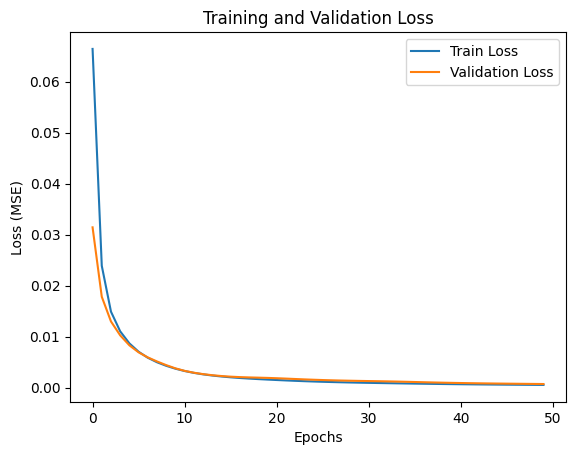

In [168]:
# Define input shape
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)


# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

# Create the model
model = create_bidirectional_lstm(input_shape=input_shape)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Adjust as needed
    batch_size=64,  # Adjust as needed
    verbose=1,  # 1 shows progress after each epoch
    callbacks=[early_stopping]  # Include early stopping
)

# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss (MSE): {val_loss}")
print(f"Validation MAE: {val_mae}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [169]:
import numpy as np
import pandas as pd

# Predict returns for the validation set
y_pred = model.predict(X_val).flatten()  # Predicted returns (flattened to 1D)
y_true = y_val  # True returns from validation set

# Initialize variables
position = 0  # Current position: 1 = in the market, 0 = out of the market
cumulative_return = 1  # Starting with 1 (100% initial capital)
strategy_returns = []  # To store daily returns from the strategy

# Iterate over the predicted and true returns
for i in range (0,len(y_pred)):
    pred_return = y_pred[i]
    true_return = y_true[i]
    if pred_return > 0 and position == 0:
        # Buy if predicted return is positive and currently out of the market
        position = 1
    elif pred_return < 0 and position == 1:
        # Sell if predicted return is negative and currently in the market
        position = 0
    
    # Calculate daily return based on true return if in the market
    five_day_return = true_return if position == 1 else 0
    #daily_return = true_return if position == 1 else 0
    strategy_returns.append(five_day_return)

    # Update cumulative return
    cumulative_return *= (1 + five_day_return)

# Convert strategy returns to a DataFrame for analysis
'''strategy_df = pd.DataFrame({
    "True Return": y_true,
    "Predicted Return": y_pred,
    "Strategy Return": strategy_returns
})'''

# Print cumulative return
print(f"Cumulative Return: {cumulative_return - 1:.2%}")  # As a percentage

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Cumulative Return: 6.33%


In [170]:
# Calculate true cumulative return (buy-and-hold strategy)
true_cumulative_return = np.prod(cumulative_return)  # Compounded return

# Calculate strategy cumulative return
strategy_cumulative_return = np.prod(1 + np.array(strategy_returns)) - 1  # Compounded return

print(f"True Buy-and-Hold Cumulative Return: {true_cumulative_return:.2%}")
print(f"Strategy Cumulative Return: {strategy_cumulative_return:.2%}")


True Buy-and-Hold Cumulative Return: 106.33%
Strategy Cumulative Return: 6.33%


In [171]:
# Directional Accuracy
directional_accuracy = np.mean((y_pred > 0) == (y_val > 0))
print(f"Directional Accuracy: {directional_accuracy:.2%}")

print(f"Mean of Predicted Returns: {np.mean(y_pred)}")
print(f"Mean of Actual Returns: {np.mean(y_val)}")



Directional Accuracy: 50.93%
Mean of Predicted Returns: -0.0002884639543481171
Mean of Actual Returns: 0.00026095485901919473


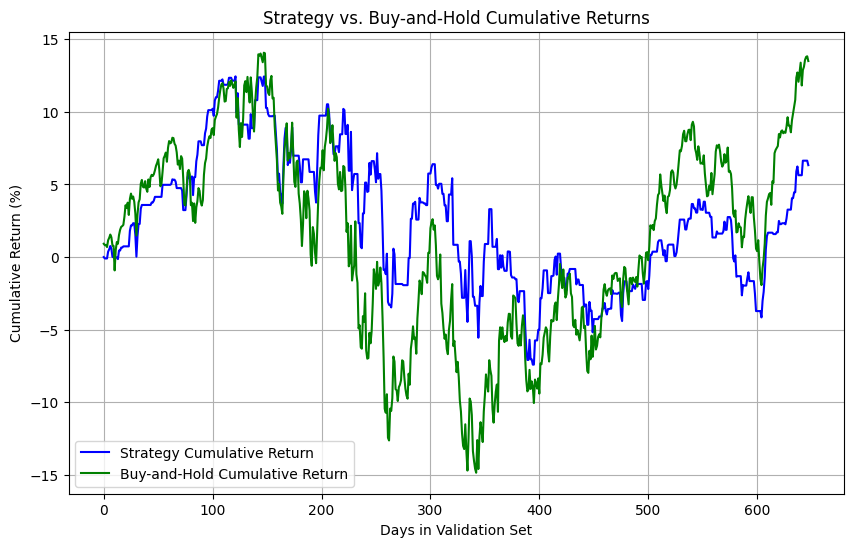

In [172]:
# Calculate cumulative returns for plotting
strategy_cumulative = (np.cumprod(1 + np.array(strategy_returns)) - 1) * 100
true_cumulative = (np.cumprod(1 + y_true) - 1) * 100

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(strategy_cumulative, label="Strategy Cumulative Return", color='blue')
plt.plot(true_cumulative, label="Buy-and-Hold Cumulative Return", color='green')
plt.xlabel("Days in Validation Set")
plt.ylabel("Cumulative Return (%)")
plt.title("Strategy vs. Buy-and-Hold Cumulative Returns")
plt.legend()
plt.grid()
plt.show()

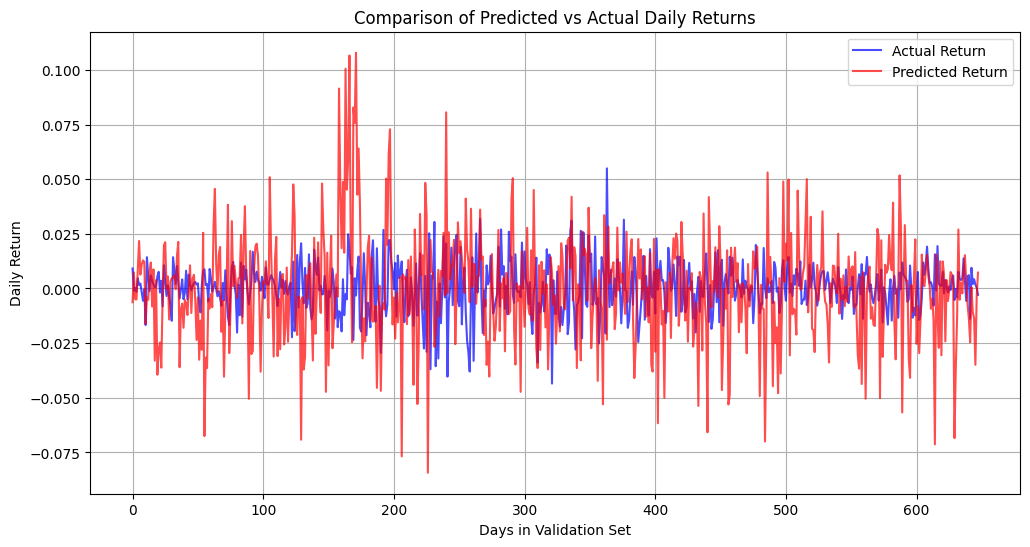

In [173]:
import matplotlib.pyplot as plt

# Plot predicted vs. actual returns
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual Return', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Return', color='red', alpha=0.7)
plt.xlabel("Days in Validation Set")
plt.ylabel("Daily Return")
plt.title("Comparison of Predicted vs Actual Daily Returns")
plt.legend()
plt.grid()
plt.show()
